In [15]:
from config import set_project_root
set_project_root()

In [17]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns
from research.datasets import CRSP

In [18]:
# Read in crsp monthly data

df = CRSP().df.copy()

df.head()

LOADING CLEAN FILE


,permno,date,cusip,shrcd,exchcd,ticker,shrout,vol,prc,ret
0,10000,1986-02-28,68391610,10.0,3.0,OMFGA,3680.0,828.0,3.25000,-0.257143
1,10000,1986-03-31,68391610,10.0,3.0,OMFGA,3680.0,1078.0,4.43750,0.365385
2,10000,1986-04-30,68391610,10.0,3.0,OMFGA,3793.0,957.0,4.00000,-0.098592
3,10000,1986-05-30,68391610,10.0,3.0,OMFGA,3793.0,1074.0,3.10938,-0.222656
4,10000,1986-06-30,68391610,10.0,3.0,OMFGA,3793.0,1069.0,3.09375,-0.005025


In [19]:
# In sample
start = np.datetime64('1929-01-01')
end = np.datetime64('1982-12-31')

df = df[(df['date'] >= start) & (df['date'] <= end)]

df = df.reset_index(drop=True)

df

,permno,date,cusip,shrcd,exchcd,ticker,shrout,vol,prc,ret
0,10006,1929-01-31,00080010,10.0,1.0,None,600.0,359.0,99.2500,0.011465
1,10006,1929-02-28,00080010,10.0,1.0,None,600.0,140.0,99.5000,0.002519
2,10006,1929-03-28,00080010,10.0,1.0,None,600.0,634.0,100.7500,0.027638
3,10006,1929-04-30,00080010,10.0,1.0,None,600.0,127.0,98.5000,-0.022333
4,10006,1929-05-31,00080010,10.0,1.0,None,600.0,107.0,94.0000,-0.045685
...,...,...,...,...,...,...,...,...,...,...
1226612,92946,1982-07-30,92922210,11.0,3.0,VYQT,1870.0,NaN,NaN,NaN
1226613,92946,1982-08-31,92922210,11.0,3.0,VYQT,1870.0,NaN,NaN,NaN
1226614,92946,1982-09-30,92922210,11.0,3.0,VYQT,1870.0,NaN,NaN,NaN
1226615,92946,1982-10-29,92922210,11.0,3.0,VYQT,1870.0,NaN,NaN,NaN


In [20]:
# Cleaning

df = df[['permno', 'ticker', 'date', 'prc', 'ret']].copy()

df['mdt'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m")
df['month'] = pd.to_datetime(df['date']).dt.strftime("%m")

df.head()

,permno,ticker,date,prc,ret,mdt,month
0,10006,None,1929-01-31,99.25,0.011465,1929-01,01
1,10006,None,1929-02-28,99.50,0.002519,1929-02,02
2,10006,None,1929-03-28,100.75,0.027638,1929-03,03
3,10006,None,1929-04-30,98.50,-0.022333,1929-04,04
4,10006,None,1929-05-31,94.00,-0.045685,1929-05,05


In [21]:
# Calculate Reversal feature
window = 1

# Log Returns
df['logret'] = np.log1p(df['ret'])

# Reversal from t-1 to t (also know as 1 month momentum)
df['rev_1'] = df.groupby('permno')['logret'].rolling(1,1).sum().reset_index(drop=True)
df['rev_1'] = df.groupby('permno')['rev_1'].shift(1)

# Reversal from t-12 to t (also know as 1 month momentum)
df['rev_12'] = df.groupby('permno')['logret'].rolling(12,12).sum().reset_index(drop=True)
df['rev_12'] = df.groupby('permno')['rev_12'].shift(1)

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev_1,rev_12
0,10006,None,1929-01-31,99.2500,0.011465,1929-01,01,0.011400,NaN,NaN
1,10006,None,1929-02-28,99.5000,0.002519,1929-02,02,0.002516,0.011400,NaN
2,10006,None,1929-03-28,100.7500,0.027638,1929-03,03,0.027263,0.002516,NaN
3,10006,None,1929-04-30,98.5000,-0.022333,1929-04,04,-0.022586,0.027263,NaN
4,10006,None,1929-05-31,94.0000,-0.045685,1929-05,05,-0.046761,-0.022586,NaN
...,...,...,...,...,...,...,...,...,...,...
1226612,92946,VYQT,1982-07-30,NaN,NaN,1982-07,07,NaN,NaN,NaN
1226613,92946,VYQT,1982-08-31,NaN,NaN,1982-08,08,NaN,NaN,NaN
1226614,92946,VYQT,1982-09-30,NaN,NaN,1982-09,09,NaN,NaN,NaN
1226615,92946,VYQT,1982-10-29,NaN,NaN,1982-10,10,NaN,NaN,NaN


In [22]:
# Filtering by prc greater than 5 and months that momentum is known

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("rev_1 == rev_1 and rev_12 == rev_12 and prclag >= 5").reset_index(drop=True)

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev_1,rev_12,prclag
0,10006,None,1930-01-31,80.2500,0.028846,1930-01,01,0.028438,-0.078590,-0.164534,78.0000
1,10006,None,1930-02-28,79.0000,-0.015576,1930-02,02,-0.015699,0.028438,-0.147496,80.2500
2,10006,None,1930-03-31,70.0000,-0.094937,1930-03,03,-0.099751,-0.015699,-0.165711,79.0000
3,10006,None,1930-04-30,55.2500,-0.210714,1930-04,04,-0.236627,-0.099751,-0.292724,70.0000
4,10006,None,1930-05-29,54.0000,-0.022624,1930-05,05,-0.022884,-0.236627,-0.506765,55.2500
...,...,...,...,...,...,...,...,...,...,...,...
905041,86239,CF,1971-08-31,23.8750,0.174390,1971-08,08,0.160749,-0.053425,0.049042,20.5000
905042,86239,CF,1971-09-30,22.4375,-0.060209,1971-09,09,-0.062098,0.160749,0.205952,23.8750
905043,86239,CF,1971-10-29,21.7500,-0.030641,1971-10,10,-0.031120,-0.062098,0.227937,22.4375
905044,86239,CF,1971-11-30,22.5000,0.034483,1971-11,11,0.033902,-0.031120,0.200332,21.7500


In [23]:
# Reversal decile bins
df['rev_1_bins'] = df.groupby("mdt")['rev_1'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) # I would like to not drop dulplicates
df['rev_12_bins'] = df.groupby("mdt")['rev_12'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) # I would like to not drop dulplicates

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev_1,rev_12,prclag,rev_1_bins,rev_12_bins
0,10006,None,1930-01-31,80.2500,0.028846,1930-01,01,0.028438,-0.078590,-0.164534,78.0000,2,6
1,10006,None,1930-02-28,79.0000,-0.015576,1930-02,02,-0.015699,0.028438,-0.147496,80.2500,3,6
2,10006,None,1930-03-31,70.0000,-0.094937,1930-03,03,-0.099751,-0.015699,-0.165711,79.0000,3,6
3,10006,None,1930-04-30,55.2500,-0.210714,1930-04,04,-0.236627,-0.099751,-0.292724,70.0000,0,3
4,10006,None,1930-05-29,54.0000,-0.022624,1930-05,05,-0.022884,-0.236627,-0.506765,55.2500,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905041,86239,CF,1971-08-31,23.8750,0.174390,1971-08,08,0.160749,-0.053425,0.049042,20.5000,4,1
905042,86239,CF,1971-09-30,22.4375,-0.060209,1971-09,09,-0.062098,0.160749,0.205952,23.8750,9,4
905043,86239,CF,1971-10-29,21.7500,-0.030641,1971-10,10,-0.031120,-0.062098,0.227937,22.4375,2,5
905044,86239,CF,1971-11-30,22.5000,0.034483,1971-11,11,0.033902,-0.031120,0.200332,21.7500,5,5


In [24]:
# Form portfolios on reversal bins

# Portfolio df for summary stats
port_s1 = df.groupby(['mdt', 'rev_1_bins'])['ret'].mean().unstack(level=['rev_1_bins'])*100
port_s12 = df.groupby(['mdt', 'rev_12_bins'])['ret'].mean().unstack(level=['rev_12_bins'])*100

# Drop rows from port where we don't know the holding return
port_s1 = port_s1.dropna()
port_s12 = port_s12.dropna()

# Spread portfolio: Long loser. Short winner.
port_s1['spread'] = port_s1[0] - port_s1[9]
port_s12['spread'] = port_s12[9] - port_s12[0]

display(port_s1, port_s12)

rev_1_bins,0,1,2,3,4,5,6,7,8,9,spread
mdt,,,,,,,,,,,
1929-10,-37.804767,-23.421400,-14.512967,-13.894467,-22.594500,-21.198567,-18.789267,-18.704900,-10.195067,-33.685950,-4.118817
1929-11,-22.520000,-16.818633,-12.179983,-18.834783,-14.870183,-13.009467,-16.300467,-8.948183,-9.216850,2.564814,-25.084814
1929-12,-2.971350,0.642871,2.030865,2.466771,-1.689989,1.349319,-2.911306,-2.456976,-1.502912,3.691639,-6.662989
1930-01,19.580132,13.817648,11.625796,5.019024,8.089239,5.359580,7.553729,4.900152,5.007682,5.945674,13.634458
1930-02,3.560962,-0.392213,0.664243,1.055271,3.422685,2.746004,2.401278,4.910430,3.679669,4.359190,-0.798229
...,...,...,...,...,...,...,...,...,...,...,...
1982-08,10.416762,8.513508,8.806708,8.217682,7.071643,6.440063,7.687658,7.302691,8.288425,6.787634,3.629128
1982-09,3.197169,4.692532,6.111418,6.341358,5.400610,4.561187,2.930671,2.765737,1.711848,-0.269506,3.466675
1982-10,18.271886,15.289763,12.803402,11.362297,11.481451,13.128085,11.730316,13.710382,12.917500,13.262324,5.009562


rev_12_bins,0,1,2,3,4,5,6,7,8,9,spread
mdt,,,,,,,,,,,
1929-10,-28.903467,-14.744433,-22.467800,-25.435300,-13.780600,-19.005767,-15.903833,-27.982100,-12.892600,-33.685950,-4.782483
1929-11,-22.295443,-16.308633,-15.804567,-11.484133,-12.750183,-13.962117,-5.428350,-7.806433,-4.730567,-16.434229,5.861214
1929-12,-2.594167,-0.289747,-0.781976,-1.649571,-1.188267,0.022231,-0.867753,2.286500,1.251276,2.406250,5.000417
1930-01,21.239566,13.620020,12.662304,7.152690,7.037278,5.906863,6.106028,3.303986,5.625462,4.167874,-17.071692
1930-02,4.554163,2.265077,1.697576,2.551681,-0.384725,2.536594,-0.260325,3.399020,4.118860,5.963384,1.409221
...,...,...,...,...,...,...,...,...,...,...,...
1982-08,11.733734,10.744038,8.489342,8.385066,6.805357,6.766260,7.189639,6.878501,6.190630,6.342927,-5.390806
1982-09,-2.208275,3.062053,3.330778,3.505686,4.293019,4.686520,4.774547,4.683938,5.129154,5.891293,8.099568
1982-10,15.503688,13.874272,12.469200,13.393431,12.007899,11.935650,12.574922,11.384775,12.675911,18.202991,2.699303


In [25]:
from tabulate import tabulate

def table(data: pd.DataFrame, title: str = ""):
    return title + "\n" + tabulate(data, headers='keys', tablefmt='heavy_grid') + "\n"

In [26]:
# Summary

rev_1_summary = summary(port_s1).loc[['mean','std','tstat']].round(3)
rev_12_summary = summary(port_s12).loc[['mean','std','tstat']].round(3)

print(table(data=rev_1_summary,title="1 Month Reversal Portfolios"))
print(table(data=rev_12_summary,title="12 Month Reversal Portfolio"))

1 Month Reversal Portfolios
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┓
┃       ┃     0 ┃     1 ┃     2 ┃     3 ┃     4 ┃     5 ┃     6 ┃     7 ┃     8 ┃     9 ┃   spread ┃
┣━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━━━━┫
┃ mean  ┃ 1.9   ┃ 1.531 ┃ 1.262 ┃ 1.194 ┃ 1.127 ┃ 1.088 ┃ 0.969 ┃ 0.886 ┃ 0.722 ┃ 0.487 ┃    1.412 ┃
┣━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━━━━┫
┃ std   ┃ 9.274 ┃ 8.122 ┃ 7.469 ┃ 7.105 ┃ 6.9   ┃ 6.9   ┃ 7.015 ┃ 7.108 ┃ 7.49  ┃ 8.043 ┃    4.929 ┃
┣━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━━━━┫
┃ tstat ┃ 5.178 ┃ 4.766 ┃ 4.271 ┃ 4.248 ┃ 4.128 ┃ 3.986 ┃ 3.491 ┃ 3.149 ┃ 2.437 ┃ 1.532 ┃    7.244 ┃
┗━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━━━━┛

12 Month Reversal Portfolio
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳

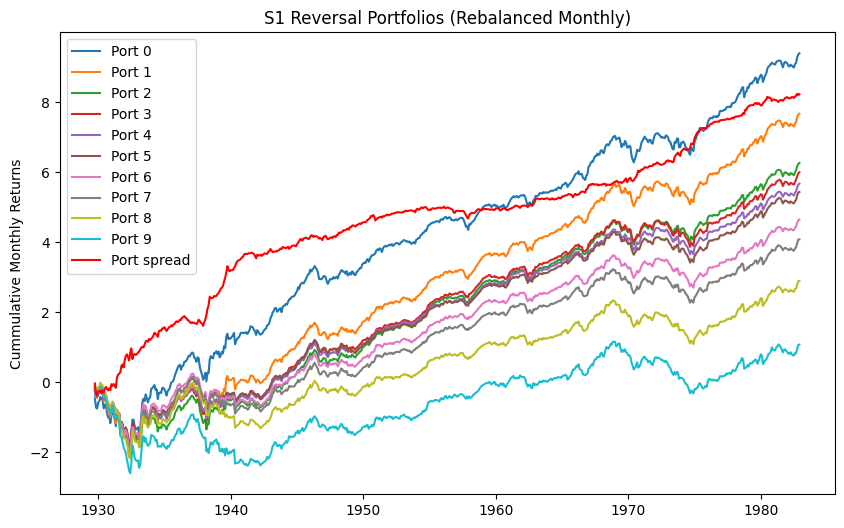

In [27]:
# Log return dataframe
log_ret = np.log1p(port_s1/100)

# Cummulative return dataframe
cum_ret = log_ret.cumsum()
cum_ret.index = pd.to_datetime(cum_ret.index)

# Lineplot
plt.figure(figsize=(10,6))

for col in cum_ret.columns:
    color = 'red' if col == 'spread' else None
    plt.plot(cum_ret[col], label=f"Port {col}", color=color)

plt.title("S1 Reversal Portfolios (Rebalanced Monthly)")
plt.ylabel("Cummulative Monthly Returns")
plt.legend()
plt.show()

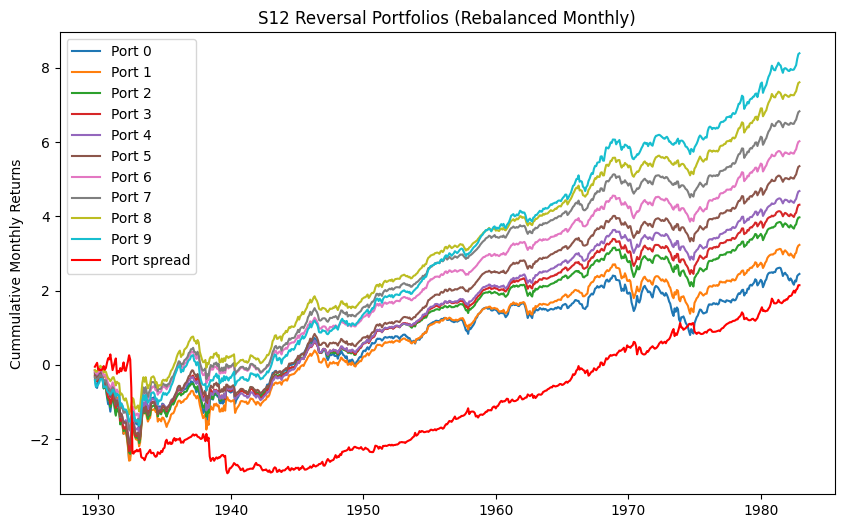

In [28]:
# Log return dataframe
log_ret = np.log1p(port_s12/100)

# Cummulative return dataframe
cum_ret = log_ret.cumsum()
cum_ret.index = pd.to_datetime(cum_ret.index)

# Lineplot
plt.figure(figsize=(10,6))

for col in cum_ret.columns:
    color = 'red' if col == 'spread' else None
    plt.plot(cum_ret[col], label=f"Port {col}", color=color)

plt.title("S12 Reversal Portfolios (Rebalanced Monthly)")
plt.ylabel("Cummulative Monthly Returns")
plt.legend()
plt.show()